In [76]:
import os
import rdkit
import random
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem

from datasets.sampler import StreamSampler


def fingerprint(mol, r=3, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits)

class Mol():
    def __init__(self, line, column_titles, step):
        self.line = line
        self.step = step
        self.smiles = line[-1]
        self.score_dict = {k : v for k, v in zip(column_titles, line)}
        
    def __hash__(self):
        return hash(self.smiles)
    
    def __eq__(self, other):
        if not isinstance(other, type(self)): return NotImplemented
        return self.smiles == other.smiles
    
    def is_success(self):
        ddict = self.score_dict
        if ddict.get('gsk3b'):
            if float(ddict['gsk3b']) < 0.5: return False
        if ddict.get('jnk3 '):
            if float(ddict['jnk3 ']) < 0.5: return False
        if ddict.get('qed  '):
            if float(ddict['qed  ']) < 0.6: return False
        if ddict.get('sa   '):
            if float(ddict['sa   ']) < .67: return False
        return True
    
class MolList():
    def __init__(self, mols=[]):
        self.mols = []
        self.column_titles = None
        
    def __len__(self):
        return len(self.mols)
    
    def __getitem__(self, index):
        return self.mols[index]
        
    def sort_mols_by_step_(self):
        self.mols = sorted(list(self.mols), key=lambda mol: mol.step)

    def load_mols_(self, run_dir, file_name='mols.txt', S=10000, r=1./100, succ=True):
        if file_name == 'mols_sampled.txt':
            mols = []
            with open(os.path.join(run_dir, file_name), 'r') as f:
                lines = f.readlines()
                lines = [line.strip().split('\t') for line in lines]

            column_titles = lines[0]
            for line in lines[1:]:
                step = int(line[0])
                line = line[1:]
                mols.append(Mol(line, column_titles, step))
            self.column_titles = column_titles
            self.mols = mols

        elif file_name == 'mols.txt':
            mols_uniq = set()
            column_titles = []
            sampler = StreamSampler(S=S)
            with open(os.path.join(run_dir, file_name), 'r') as f:
                cnt = 0
                step = None
                pbar = tqdm()
                while True:
                    line = f.readline()
                    if not line: break
                        
                    pbar.update(1)
                    cnt += 1
                    # if cnt == 100000: break

                    line = line.strip().split('\t')
                    if   line[0].startswith('molecules'): 
                        step = int(line[0].split(' ')[-1])
                        continue
                    elif line[0] == 'score': column_titles = line
                    else:
                        if random.random() > r: continue
                        mol = Mol(line, column_titles, step)
                        if mol.smiles in mols_uniq: continue
                        mols_uniq.add(mol.smiles)
                        if not succ or mol.is_success(): 
                            sampler.update([mol])
                            
            self.column_titles = column_titles
            self.mols = sampler

        else: raise NotImplemented

    def save_mols(self, run_dir, file_name='mols_sampled.txt'):
        with open(os.path.join(run_dir, file_name), 'w') as f:
            f.write('\t'.join(['step'] + self.column_titles) + '\n')
            for mol in self.mols:
                f.write('\t'.join(['%i' % mol.step] + mol.line) + '\n')


In [77]:
run_dirs = [
    'runs/obj=gsk3b/run_00',
    'runs/obj=gsk3b,nov_nn;wght=.3/run_00',
    'runs/obj=gsk3b,nov_ad;wght=.3/run_00'
]

def sample_mols(run_dir):
    mols = MolList()
    print('sampling mols from', run_dir)
    mols.load_mols_(run_dir, 'mols.txt', r=1., succ=True)
    mols.sort_mols_by_step_()
    mols.save_mols(run_dir)
    
for run_dir in run_dirs:
    sample_mols(run_dir)

sampling mols from runs/obj=gsk3b/run_00


3201280it [00:07, 425670.55it/s]


sampling mols from runs/obj=gsk3b,nov_nn;wght=.3/run_00


4581832it [00:10, 444596.18it/s]


sampling mols from runs/obj=gsk3b,nov_ad;wght=.3/run_00


1840736it [00:04, 400607.65it/s]


In [78]:
### plot molecules by step

import rdkit
import numpy as np
from rdkit import Chem
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

def tsne(mols):
    fps = np.array([
        fingerprint(Chem.MolFromSmiles(
        mol.smiles)) for mol in tqdm(mols)])
    fps = TruncatedSVD(n_components=50).fit_transform(fps)
    print('computing tsne...')
    X = TSNE(n_components=2, perplexity=50, n_jobs=32, random_state=42).fit_transform(fps)
    return X

In [79]:
import matplotlib.pyplot as plt

def plot_by_step(mols, X=None, split_by_num=False):
    if X is None: X = tsne(mols)
    print('plotting by', ['step', 'num'][split_by_num])

    n_rows, n_cols = 2, 4
    n_plots = n_rows * n_cols

    n = len(mols) if split_by_num else mols[-1].step
    n_per_plot = n // (n_plots-1)

    row, col = 0, 0
    current_range = n_per_plot
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,10))
    for i in range(X.shape[0]):
        split_idx = i if split_by_num else mols[i].step
        if split_idx >= current_range:
            current_range += n_per_plot
            col += 1
            if col % n_cols == 0:
                row += 1
                col = 0
            axs[row, col].scatter(x=X[:i,0], y=X[:i,1], c='grey', s=1)
        axs[row, col].scatter(x=X[i,0], y=X[i,1], c='blue', s=1)
    plt.show()
    
def plot_single(run_dir):
    mols = MolList()
    mols.load_mols_(run_dir, 'mols_sampled.txt')
    
    X = tsne(mols)
    plot_by_step(mols, X)
    # plot_by_step(mols, X, split_by_num=True)

100%|██████████| 10000/10000 [00:03<00:00, 2996.72it/s]


computing tsne...
plotting by step


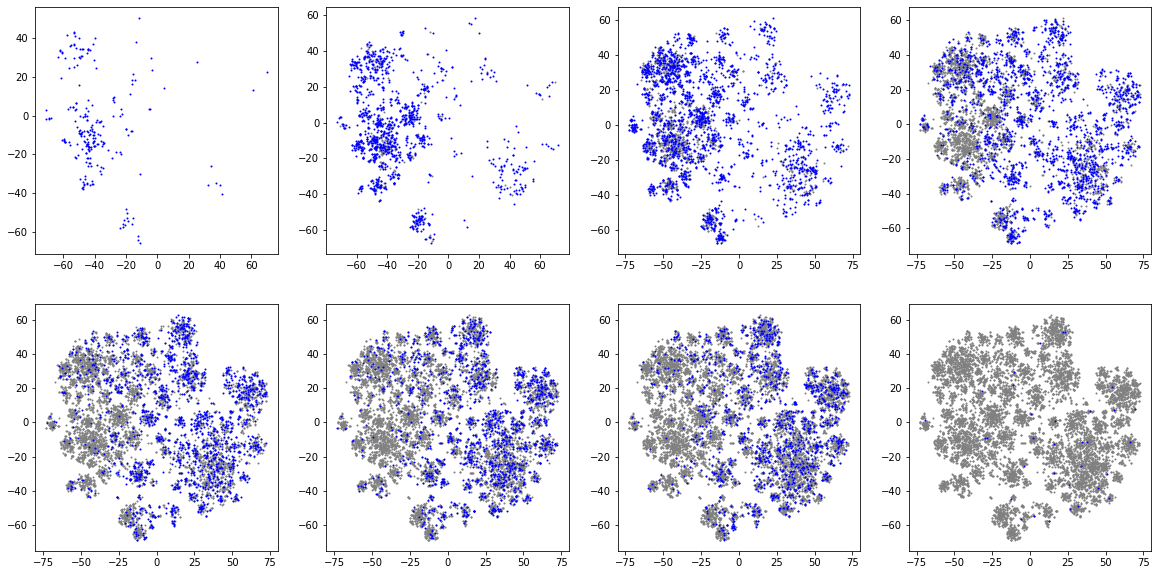

In [80]:
plot_single('runs/obj=gsk3b/run_00')

100%|██████████| 10000/10000 [00:03<00:00, 3136.45it/s]


computing tsne...
plotting by step


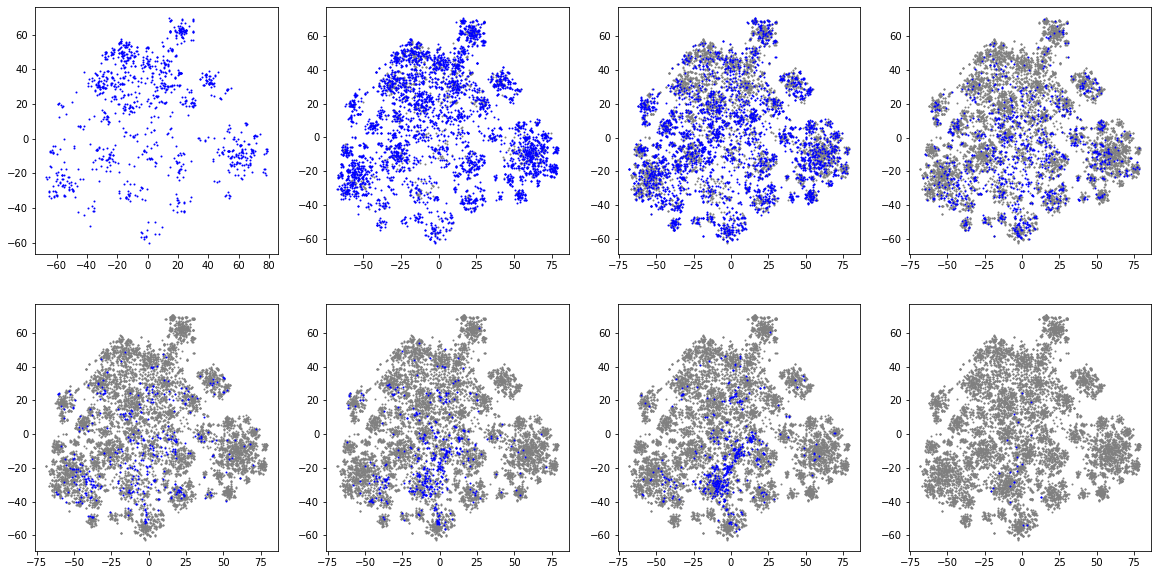

In [81]:
plot_single('runs/obj=gsk3b,nov_nn;wght=.3/run_00')

100%|██████████| 10000/10000 [00:03<00:00, 3175.36it/s]


computing tsne...
plotting by step


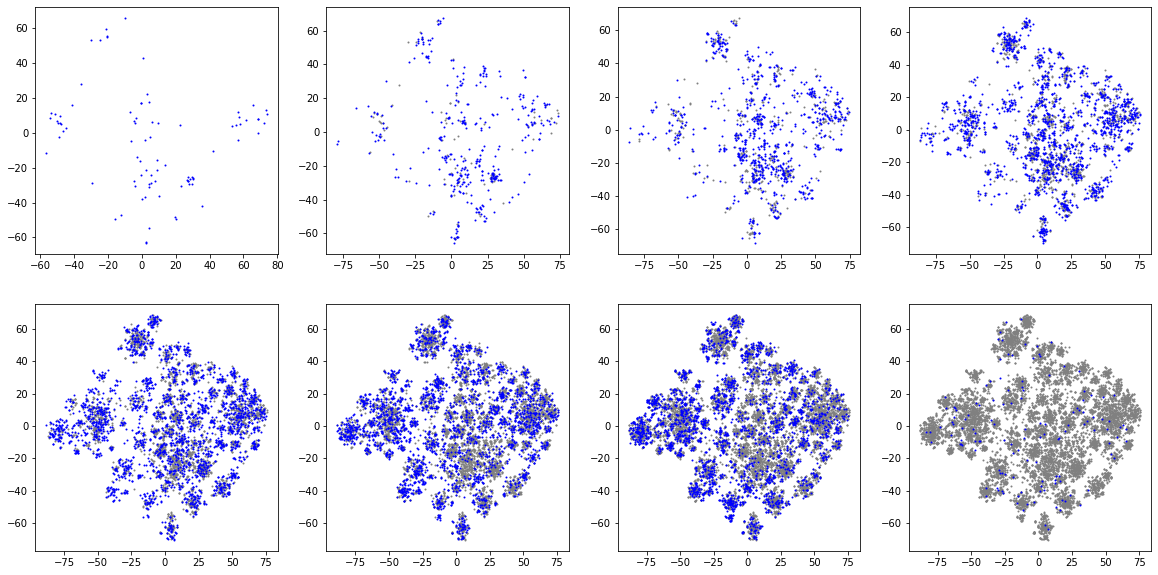

In [82]:
plot_single('runs/obj=gsk3b,nov_ad;wght=.3/run_00')

In [85]:
### compare generated molecules

mols_list = []
for run_dir in run_dirs:
    mols = MolList()
    print('loading run dir:', run_dir)
    mols.load_mols_(run_dir, 'mols_sampled.txt')
    mols_list.append(mols)

loading run dir: runs/obj=gsk3b/run_00
loading run dir: runs/obj=gsk3b,nov_nn;wght=.3/run_00
loading run dir: runs/obj=gsk3b,nov_ad;wght=.3/run_00


In [86]:
mols_tsne = []
for mols in mols_list:
    mols_tsne += mols.mols
tsnes = np.split(tsne(mols_tsne), len(mols_list))

100%|██████████| 30000/30000 [00:09<00:00, 3088.78it/s]


computing tsne...


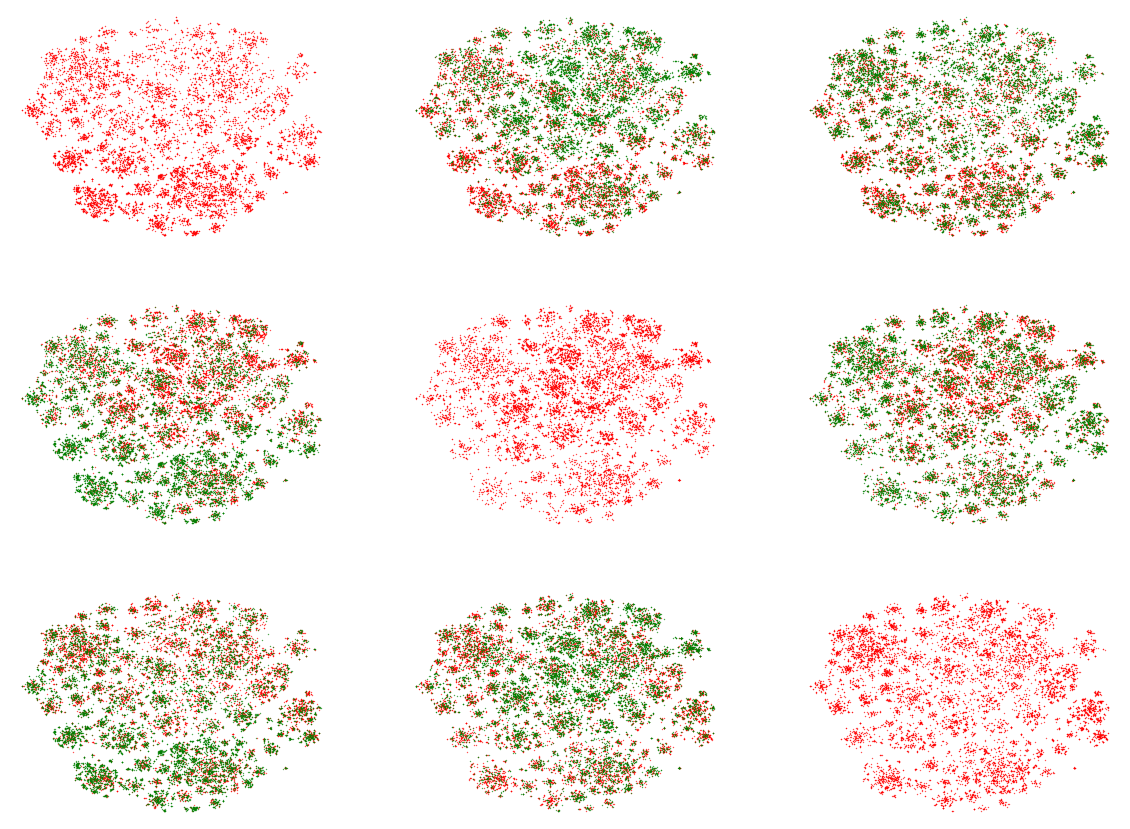

In [104]:
n_rows = len(mols_list)
fig, axs = plt.subplots(n_rows, n_rows, figsize=(20,15))
for i in range(n_rows):
    X = tsnes[i]
    for j in range(n_rows):
        axs[i][j].axis('off')
        axs[i][j].scatter(x=X[:,0], y=X[:,1], c='red', s=.1)
for i in range(n_rows):
    X = tsnes[i]
    for j in range(n_rows):
        if i == j: continue
        axs[j][i].scatter(x=X[:,0], y=X[:,1], c='green', s=.1)
plt.show()